# Tutorial 1 - Building a Monte Carlo generator

- Welcome! 
- Questions, anything unclear? Please ask any of us anytime!
- Plan for today:
  - write a very simple and short Monte Carlo program and produce LO predictions
  - calculate structure functions and compare with data; improve the theory predictions and see the impact
  - Less focus on *why* and more focus on *how*
- For the exercises: if you'd like team up, please do! If you want to solve everything yourself that's also fine!

## Technical information

1. Open a terminal and `cd` to your `como-2025` directory and `git pull` to update it
2. Activate the `env_como` environment to run this notebook:
   ```
   conda activate env_como
   jupyter lab w1t1-nlo-crash-course/introduction.ipynb
   ```
   you should now see this notebook!
3. we finally need a PDF set with a non-zero photon PDF:

In [1]:
!lhapdf install NNPDF31_nnlo_as_0118_luxqed

PDF already installed: NNPDF31_nnlo_as_0118_luxqed (use --upgrade to force install)


# Motivation: what do we need theory predictions for?

- With the standard model of particle physics, we're often interested in these two tasks:
  1. Extract quantities we can't calculate: If we trust data and theory, we often want to extract quantities that are hard/impossible to calculate! For instance, parton distribution functions (PDFs), see picture below.
  2. Answer: how good is the standard model? To answer this question, we must compare theory predictions with experimental measurements, using (universal!) PDFs as input
  
![fitting PDFs](figures/Fit.png)

- theory predictions important (not the only) ingredient to answer these types of questions

# How do we calculate a prediction?

- there's a 'recipe' that we will present
- important ingredients in the following:
  1. factorization (covered in Melissa's lectures) and
  2. perturbation theory (you should know this from quantum mechanics)
  3. interpolation grids (technical)

## 1. Factorization

- Many colliders use bound states: protons (LHC), anti-protons (Tevatron), or heavier nuclei like lead (LHC)
- Bound states are very difficult objects, but if we
  - either scatter them off each other with high enough energies
  - or if we probe them using leptons
  we usually assume that short-distance dynamics (scattering process) *factorizes* from long-distance dynamics (interaction in the hadron)
- Essentially we're assuming that in the very short moment when the scattering happens we don't scatter the bound states but rather one constituent of each bound states which we call *partons* and we neglect the rest
- Partons are elementary particles (quarks $\mathrm{q}$, gluons $\mathrm{g}$, but also photons $\gamma$, leptons $\ell$ and so on), and we can easily calculate with them

### Parton distribution functions (PDFs)

- Rough idea: The translation between *partonic* cross sections and *hadronic* cross sections is provided by PDFs $f_a^h (x)$, which describe the 'probability' of finding a parton $a$ in hadron $h$ with momentum fraction $x \in [0, 1]$ during a collision
- for one hadron (for instance HERA):
  $$ \left\langle \frac{\sigma^{h \ell \to F}}{\mathrm{d} \mathcal{O}} \right\rangle = \sum_{a} \int_0^1 \mathrm{d} z f_a^h (z) \frac{\sigma_{ab \to F} (z)}{\mathrm{d} \mathcal{O}} $$
- for two hadrons (for instance LHC):
  $$ \left\langle \frac{\sigma^{hh \to F}}{\mathrm{d} \mathcal{O}} \right\rangle = \sum_{a,b} \int \mathrm{d} x_1 \mathrm{d} x_2 f_a^h (x_1) f_b^h (x_2) \frac{\sigma_{ab \to F} (x_1, x_2)}{\mathrm{d} \mathcal{O}} $$
- these are our 'master formulae':
  1. We can calculate the hadronic cross sections $\sigma_{ab \to F} (x_1, x_2)/\mathrm{d} \mathcal{O}$ using the previously determined PDFs
  2. or we use predictions and the corresponding measurements to fit PDFs
- LHAPDF, which you should have installed, is the software to access the numerical values of PDFs

## 2. Perturbation theory: calculating a partonic cross section

- Standard model Lagrangian $\mathcal{L}_\text{SM}$, solve the equations of motion, just like in classical mechanics
- Well, not quite: EOMs are coupled, non-linear differential equations
- A good tool is perturbation theory: divide Lagrangian into free fields + small perturbation
- In the SM the perturbation is measured in the couplings $\alpha_s (M_\mathrm{Z}^2) = 0.118$ and $\alpha(0) \approx 1/137 \approx 0.0073$
- expand in those two couplings:
  $$ \frac{\sigma_{ab} (x_1, x_2)}{\mathrm{d} \mathcal{O}} = \sum_{n,m} \alpha_\mathrm{s}^n \alpha^m \frac{\sigma_{ab}^{n,m} (x_1, x_2)}{\mathrm{d} \mathcal{O}} $$
- since $\alpha_s \gg \alpha$ we usually look only at the lowest order $m$ and calculate corrections in $n$: QCD corrections
- this isn't always reliable, sometimes electroweak (EW) corrections are needed

## 3. Interpolation grids: predictions independent of their PDFs and strong coupling

Inserting the perturbative expansion into the master formula:

$$ \left\langle \frac{\sigma^{hh \to F}}{\mathrm{d} \mathcal{O}} \right\rangle = \sum_{a,b} \sum_{n,m} \int \mathrm{d} x_1 \mathrm{d} x_2 f_a^h (x_1) f_b^h (x_2) \alpha_\mathrm{s}^n \alpha^m \frac{\sigma_{ab \to F}^{n,m} (x_1, x_2)}{\mathrm{d} \mathcal{O}} $$

We can construct $\sigma_{ab \to F}^{n,m} (x_1, x_2) / \mathrm{d} \mathcal{O}$ and call that 'interpolation grid'. They have the advantage that one can very quickly (less than a second) perform the integrals above with any PDF set.

# Leading-order (LO) calculations recipe

In the following we will calculate

- the cross section of the production of a same-flavour opposite-sign (SFOS) lepton-pair (also known as Drell-Yan lepton-pair production), for instance muons
- at the LHC: $\mathrm{p}\mathrm{p} \to \ell\bar{\ell}$ @ 7 TeV,
- differentially in the rapidity of the lepton pair,
- in the setup given by <https://arxiv.org/abs/1310.7291>.

We'll write a Monte Carlo integrator that calculates a part of this process and produces an interpolation grid.

## 1. Write down observable definition and master formula

We use the master formula for two incoming protons:

$$ \sigma^{\mathrm{p}\mathrm{p} \to \ell\bar{\ell}} = \sum_{a,b} \int \mathrm{d} x_1 \mathrm{d} x_2 f_a^\mathrm{p} (x_1) f_b^\mathrm{p} (x_2) \sigma_{ab \to \ell\bar{\ell}} (x_1, x_2) $$

For simplicity we restrict ourselves to the photon-photon contribution, so $a, b = \gamma$ and use a PDF with a non-zero photon: `NNPDF31_nnlo_as_0118_luxqed`.

## 2. Draw all Feynman diagrams

You need to identify all relevant input states and all valid output states, connect them in all possible ways using the allowed vertices and propagators and assign four-momenta to them.

In our example of photon-photon scattering to SFOS lepton-pair there are two diagrams: one with a $t$-channel propagator and one with a $u$ propagator:

<img src="figures/lo-t.png" width=260 height=260 />  <img src="figures/lo-u.png" width=260 height=260 />

$$ \mathrm{i} \mathcal M_t = \bar u(p_2) (- \mathrm{i} e) \gamma_\mu \frac{\mathrm{i} ( \cancel k_1 - \cancel p_1 )}{t} (-\mathrm{i} e) \gamma_\nu u(p_2) \epsilon^\nu (k_1) \epsilon^\mu (k_2) \quad \mathrm{i} \mathcal{M}_u = \bar u(p_2) (-\mathrm{i} e) \gamma_\mu \frac{\mathrm{i} (\cancel k_2 - \cancel p_1)}{u} (- \mathrm{i} e) \gamma_\nu u(p_2) \epsilon^\nu (k_1) \epsilon^\mu (k_2) $$

## 3. Compute matrix elements

Sum all amplitudes and take the modulus squared. It is common practice to also account for the flux factor and the spin and color sums together with their eventual average. Recall to average on the input and to sum on the output.

In our example we find:
$$ \frac {1}{2 s} |\mathcal M_t + \mathcal M_u |^2 = \frac{\alpha^2}{2s} \left(\frac t u + \frac u t\right) $$

In [2]:
def photon_photon_matrix_element(s: float, t: float, u: float) -> float:
    alpha0 = 1.0 / 137.03599911
    return alpha0 * alpha0 / 2.0 / s * (t / u + u / t)

## 4. Determine phase space decomposition

Given the initial states with momenta $k_1$ and $k_2$ we need to integrate the squared matrix elements over all possible momenta, that is all momenta which fulfill momentum conservation and which are on-shell: $ p_i^2 = m_i^2 $. In general this integral (Lorentz invariant phase-space (LIPS)) is:

$$ \int \mathrm{d} \mathrm{LIPS} = \int \left( \prod_{i=1}^n \mathrm{d}^4 p_i \right) \, \delta^{(4)} \left( k_1 + k_2 - \sum_{i=1}^n p_i \right) \prod_{i = 1}^n \delta \left( p_i^2 - m_i^2 \right) $$

and has $4n$ integration dimensions, reduced to $3n - 4$ through the momentum conservation ($-4$) and on-shell conditions ($-n$).

In our example we have two massless final state particles ($n = 2$ and $m_1 = m_2 = 0$), so effectively we integrate over $3n - 4 = 2$ dimensions. We choose to integrate over these two variables:
1. $\cos \theta$, where $\theta$ measures the angle of one of the leptons w.r.t. the beam axis and
2. the angle $\phi$, which is another angle transverse to the beam axis.

Matrix elements do not depend on the angle $\phi$, since the collision is symmetric around the beam axis.

## 5. Compute phase space integrals

Our master formula,

$$ \sigma^{\mathrm{p}\mathrm{p} \to \ell\bar{\ell}} = \sum_{a,b} \int \mathrm{d} x_1 \mathrm{d} x_2 f_a^\mathrm{p} (x_1) f_b^\mathrm{p} (x_2) \sigma_{ab \to \ell\bar{\ell}} (x_1, x_2) $$

requires us to integrate over all possible momentum fractions $x_1$ and $x_2$ of the two PDFs. We do this by rewriting the integral into $\tau = x_1x_2 = \hat{s}/s$, the relative centre-of-mass energy squared (the hat refers to partonic quantities) and another independent variable $y = x_1$ (which despite it's name isn't the rapidity):

$$ \int_0^1 \mathrm{d} x_1 \int_0^1 \mathrm{d} x_2 \to \int_{\tau_0}^1 \mathrm{d} \tau \int_0^1 \mathrm{d} y$$

The exact form of this transformation isn't really important, but it is chosen such that the jacobian contains the inverse flux factor, cancelling the flux factor multiplied to the squared matrix elements above.

We approximate the integrals numerically by using a Monte Carlo integration, which computes the average of the integrand evaluated using uniformly chosen random numbers $r_1, r_2, r_3$:

$$ \int_0^1 \mathrm{d} r_1 \int_0^1 \mathrm{d} r_2 \int_0^1 \mathrm{d} r_3 g(r_1, r_2, r_3) \approx \frac{1}{N} \sum_{i=1}^N g(r_1^i, r_2^i, r_3^i) $$

Translated to Python code this reads:

In [8]:
from typing import Tuple
import numpy as np
import math

def hadronic_ps_gen(
    mmin: float, mmax: float
) -> Tuple[float, float, float, float, float, float]:
    r"""Hadronic phase space generator.

    Parameters
    ----------
    mmin :
        minimal partonic centre-of-mass energy :math:`\sqrt{s_{min}}`
    mmax :
        maximal partonic centre-of-mass energy :math:`\sqrt{s_{max}}`

    Returns
    -------
    s :
        Mandelstam s
    t :
        Mandelstam t
    u :
        Mandelstam u
    x1 :
        first momentum fraction
    x2 :
        second momentum fraction
    jacobian :
        jacobian from the uniform generation

    """
    smin = mmin * mmin
    smax = mmax * mmax

    r1 = np.random.uniform()
    r2 = np.random.uniform()
    r3 = np.random.uniform()
    
    # generate partonic x1 and x2
    tau0 = smin / smax
    tau = pow(tau0, r1)
    y = pow(tau, 1.0 - r2)
    x1 = y
    x2 = tau / y
    s = tau * smax

    jacobian = tau * np.log(tau0) * np.log(tau0) * r1

    # theta integration (in the CMS)
    cos_theta = 2.0 * r3 - 1.0
    jacobian *= 2.0

    # reconstruct invariants (in the CMS)
    t = -0.5 * s * (1.0 - cos_theta)
    u = -0.5 * s * (1.0 + cos_theta)

    # phi integration
    jacobian *= 2.0 * math.pi

    return [s, t, u, x1, x2, jacobian]

Now we can test the integration by generating a phase-space point between $s_\text{min} = (10~\text{GeV})^2$ and $s_\text{max} = (7000~\text{GeV})^2$ (our hadronic centre-of-mass energy):

In [9]:
[s, t, u, x1, x2, jacobian] = hadronic_ps_gen(10.0, 7000.0)

print("s = {}\nt = {}\nu = {}\n\nx1 = {}\nx2 = {}\n\ns + t + u = {}".format(s, t, u, x1, x2, s + t + u))

s = 71814.09850068686
t = -17618.322640990315
u = -54195.77585969654

x1 = 0.06309745515052462
x2 = 0.02322746366642661

s + t + u = 0.0


## 6. Join phase space integration and matrix elements

Finally, we have to
- put the integral together with the squared matrix elements,
- transform the phase-space variables into the well-known LAB quantities, and
- we want to simulate the setup from CMS DY 7 TeV, see: <https://arxiv.org/abs/1310.7291>

This means, we
- add phase-space cuts:
  - $ p_\mathrm{T}^\ell > 14~\text{GeV} $
  - $ |y^\ell| < 2.4 $
  - $ 60~\text{GeV} < M_{\ell\bar{\ell}} < 120~\text{GeV} $
- and we want the differential cross section w.r.t. $|y_{\ell\bar{\ell}}|$ (which is the rapidity in this case) with bin limits $0 < |y_{\ell\bar{\ell}}| < 2.4$, in steps of $0.1$.

In [10]:
import pineappl

def fill_grid(grid: pineappl.grid.Grid, calls: int):
    """Fill grid with points."""

    # in GeV^2 pbarn
    hbarc2 = 389379372.1

    # perform Monte Carlo sum
    for _ in range(calls):
        # compute phase space
        s, t, u, x1, x2, jacobian = hadronic_ps_gen(10.0, 7000.0)

        # build observables
        ptl = np.sqrt((t * u / s))
        mll = np.sqrt(s)
        yll = 0.5 * np.log(x1 / x2)
        ylp = np.abs(yll + math.acosh(0.5 * mll / ptl))
        ylm = np.abs(yll - math.acosh(0.5 * mll / ptl))

        # apply conversion factor
        jacobian *= hbarc2 / calls

        # cuts for LO for the invariant-mass slice containing the Z-peak from CMS (7 TeV): https://arxiv.org/abs/1310.7291
        if (
            ptl < 14.0
            or np.abs(yll) > 2.4
            or ylp > 2.4
            or ylm > 2.4
            or mll < 60.0
            or mll > 120.0
        ):
            # continuing means this we don't call fill below that means this event counts as zero or it 'cut away'
            continue

        # build event
        weight = jacobian * photon_photon_matrix_element(s, u, t)
        # set factorization and renormalization scale to (roughly) the Z-boson mass
        q2 = 90.0 * 90.0
    
        # fill the interpolation grid
        grid.fill(x1, x2, q2, 0, np.abs(yll), 0, weight)

We want our results stored in an interpolation grid, which is independent of PDFs and the strong coupling. To create a `Grid`, we need to give it a few bits of information. We have to tell it that

- our initial state is photon-photon, or in PDG Monte Carlo IDs `(22, 22)`
- the perturbative order in $\alpha^2$
- as per CMS's setup we bin the observable from $0$ to $2.4$ in steps of $0.1$.

In [11]:
def generate_grid(calls: int) -> pineappl.grid.Grid:
    """Generate the grid."""
    # create a new luminosity function for the $\gamma\gamma$ initial state
    lumi_entries = [pineappl.lumi.LumiEntry([(22, 22, 1.0)])]
    # only LO $\alpha_\mathrm{s}^0 \alpha^2 \log^0(\xi_\mathrm{R}) \log^0(\xi_\mathrm{F})$
    orders = [pineappl.grid.Order(0, 2, 0, 0)]
    bins = np.arange(0, 2.4, 0.1)
    params = pineappl.subgrid.SubgridParams()
    grid = pineappl.grid.Grid.create(lumi_entries, orders, bins, params)

    # fill the grid with phase-space points
    print(f"Generating {calls} events, please wait...")
    fill_grid(grid, calls)
    print("Done.")

    return grid

You can play a bit with the Monte Carlo statistics, to produce smooth results. To generate the full theory prediction, we must also use our master formula and convolute the interpolation grid with the two photon PDFs. Finally, let's plot the result:

Generating 1000000 events, please wait...
Done.
LHAPDF 6.5.5 loading /Users/evagroenendijk/anaconda3/envs/nnpdf/share/LHAPDF/NNPDF31_nnlo_as_0118_luxqed/NNPDF31_nnlo_as_0118_luxqed_0000.dat
NNPDF31_nnlo_as_0118_luxqed PDF set, member #0, version 2; LHAPDF ID = 325100


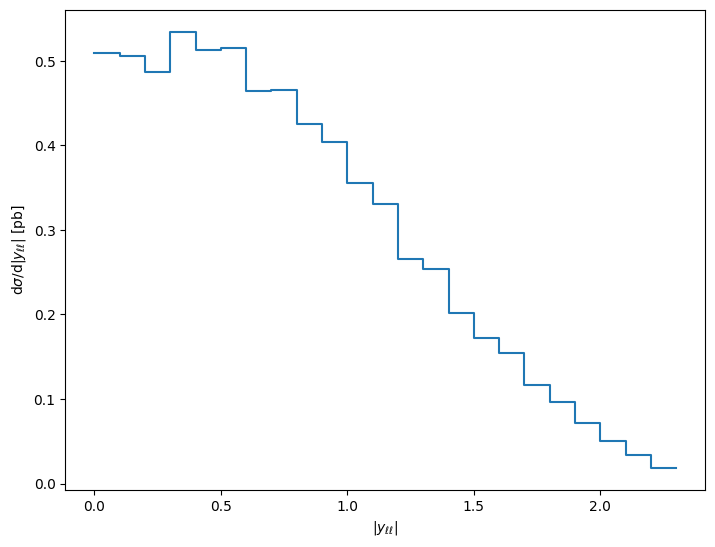

In [12]:
import lhapdf

# generate interpolation grid: increase this number!
grid = generate_grid(1000000)

# perform convolution with PDFs: this performs the x1 and x2 integrals of the partonic cross sections with the PDFs as given by our master formula
pdf = lhapdf.mkPDF("NNPDF31_nnlo_as_0118_luxqed", 0)
bins = grid.convolve_with_one(2212, pdf.xfxQ2, pdf.alphasQ2)

# matplotlib's 'step' function requires the last value to be repeated
bins = np.append(bins, bins[-1])

from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel(r"$|y_{\ell\ell}|$")
ax.set_ylabel(r"$\mathrm{d} \sigma / \mathrm{d} |y_{\ell\ell}|$ [pb]")
ax.step(np.arange(0.0, 2.4, 0.1), bins, where='post')

## Concluding remarks

This was only a piece of a full calculation. For a full calculation we'd also need to calculate:

- quark-anti-quark initial-states, $q\bar{q} \to \ell\bar{\ell}$, which are large and therefore important
- for reliable theory predictions, we should also calculate NLO and NNLO QCD predictions
- if we scan the invariant mass range of Drell-Yan, we should also calculate NLO electroweak corrections $\mathcal{O} (\alpha^3)$.

# Next-to-leading-order (NLO) calculations recipe modifications

Our considerations so far are dealing with a leading-order calculation - what changes if we go to higher perturbative orders? In order to investigate this let's consider a simpler example than Drell-Yan: the computation of DIS structure functions. Although this calculation is conceptionally much simpler it turns out that higher-order corrections bring a whole new level of complication at any level of our algorithm. We will thus refrain from giving all details, but instead try to convey the most relevant ideas.

## 2. Draw all Feynman diagrams

Starting at next-to-leading order (NLO) we need to consider genuinely new contributions: virtual corrections, real emissions, including new partonic channels. Let's discuss them in turn.

### Virtual corrections

- add propagators inside diagrams to form loops
- Example on blackboard

### Real corrections

- gluons and other particle can be emitted off any any point in the diagram
- Example on blackboard

### New partonic channels

- you need to consider also the case of new initial state partons
- Look at DIS for example (blackboard)

### Diagram generation

- in general, when there are many diagrams, an automatic program for diagram generation is needed, for instance qgraf or FeynArts
- actually "drawing" is not really needed as long as you have a way to generate them

## 3. Compute all matrix elements

### Virtual corrections

- the loop momentum appearing in loop diagrams is arbitrary and thus needs to be integrated over
- this generates singularities, which require a regularization procedure
- the triangle can be calulated by hand, more complicated examples usually require one to numerically evaluate them using so-called loop-libraries, for instance https://qcdloop.web.cern.ch

### Real corrections

- like the virtual corrections, the real corrections also contain singularities
- these singularities arise when integrating over the phase space of the additional particle

### Cancellation of singularities between real and virtual contributions

- singularities in the virtual contribution cancel against singularities in the real correction (if you choose your observables properly). The integrals themselves are different though
- Widely used method to subtract real and virtual: Catani-Seymour Dipole subtraction 

### General bookkeeping issues

- in general the number of diagrams grows factorially with the number of external particles and thus requires good bookkeeping for the corresponding mathematical terms
- automation needed everywhere: we can't evaluate more than two-handful of diagrams by hand

## 4. Determine phase space decomposition

- real corrections have one more FS particle than LO and virtual, requires different phase-space integration

## 5. Compute phase space integrals

- in DIS phase-space integrals are usually solvable using classical integration methods (good control over errors)
- for processes with many final-state particles the phase-space is $3n - 4$, for instance $n=6$ requires one to perform a 14- (+2 from PDF convolutions) dimensional integral, which requires Monte Carlo integration

## 6. Join phase space and matrix elements

- matrix elements, especially virtual corrections, are significantly more expensive than LO to evaluate
- usually requires a computing cluster

# Next up: DIS structure functions

Open `dis.ipynb`.